In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import lightgbm as lgb

from sklearn import model_selection
from sklearn.metrics import r2_score

from prophet import Prophet
import logging


In [287]:
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [2]:
# получаю данные

df_transaction = pd.read_parquet("../from_archive/transaction_df.parquet")
df_competitors = pd.read_parquet("../from_archive/df_competitors.parquet")
df_cost = pd.read_parquet("../from_archive/df_cost.parquet")
df_weather = pd.read_parquet("../from_archive/weather_df.parquet")

In [3]:
# убираю отрицательные цены и зануляю отрицательные amount

df_transaction = df_transaction[df_transaction["price"] >= 0]
df_transaction["amount"][df_transaction["amount"] < 0] = 0

In [4]:
# создаю датафрейм `df_transaction`, где даты уже дни, а `amount` взят как все продажи за каждый день

df_transaction_price = df_transaction.groupby(["place", "product", pd.Grouper(key='datetime',freq='D')])["price"].first().reset_index()
df_transaction_amount = df_transaction.groupby(["place", "product", pd.Grouper(key='datetime',freq='D')])["amount"].sum().reset_index()
df_transaction = pd.merge(df_transaction_price, df_transaction_amount, how="inner")

df_transaction.rename(columns={'datetime': 'date'}, inplace=True)

In [5]:
df_transaction

,place,product,date,price,amount
0,Анор Лондо,Целебные травы,2216-01-02,3.90,37.802874
1,Анор Лондо,Целебные травы,2216-01-03,3.90,43.264844
2,Анор Лондо,Целебные травы,2216-01-04,3.90,35.629889
3,Анор Лондо,Целебные травы,2216-01-05,3.90,37.474104
4,Анор Лондо,Целебные травы,2216-01-06,3.90,48.586827
...,...,...,...,...,...
14993,Фалькония,Эстус,2218-09-23,9.28,58.409777
14994,Фалькония,Эстус,2218-09-24,9.28,48.620474
14995,Фалькония,Эстус,2218-09-25,9.28,59.634726
14996,Фалькония,Эстус,2218-09-26,9.28,52.100924


In [6]:
# где-то есть пропуск по нескольким дням в таблице new_df_transaction

for (place, product), i in df_transaction.groupby(["place", "product"]):
    if i["date"].shape[0] != 1000:
        print((place, product), i["date"].shape[0])

('Врата Балдура', 'Эльфийская пыльца') 998


In [7]:
temp_df = df_transaction[(df_transaction["place"] == 'Врата Балдура') & (df_transaction["product"] == 'Эльфийская пыльца')]
for i in range(temp_df.shape[0] - 1):
    a = (temp_df["date"].iloc[i + 1] - temp_df["date"].iloc[i]).days
    if a > 1:
        print(f"Дата следующая за этой не найдена: ", temp_df["date"].iloc[i+1])

Дата следующая за этой не найдена:  2217-04-04 00:00:00
Дата следующая за этой не найдена:  2217-07-02 00:00:00


In [8]:
# Вставляю в df_transaction эти 2 пропуска, ставлю туда предудущие значения

temp_df_1 = temp_df[temp_df["date"] == pd.Timestamp("2217-04-02")]
temp_df_2 = temp_df[temp_df["date"] == pd.Timestamp("2217-06-30")]
price_1, amount_1 = temp_df_1["price"].values, temp_df_1["amount"].values
price_2, amount_2 = temp_df_2["price"].values, temp_df_2["amount"].values

df_transaction.loc[-1] = 0
df_transaction.loc[-1] = ['Врата Балдура', 'Эльфийская пыльца', pd.Timestamp("2217-04-03 00:00:00"), price_1[0], amount_1[0]]
df_transaction.index += 1
df_transaction.loc[-1] = ['Врата Балдура', 'Эльфийская пыльца', pd.Timestamp("2217-07-01 00:00:00"), price_2[0], amount_2[0]]
df_transaction.index += 1
df_transaction = df_transaction.set_index("date").sort_index()

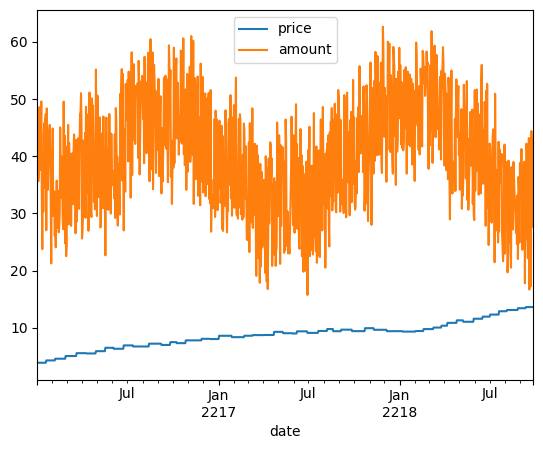

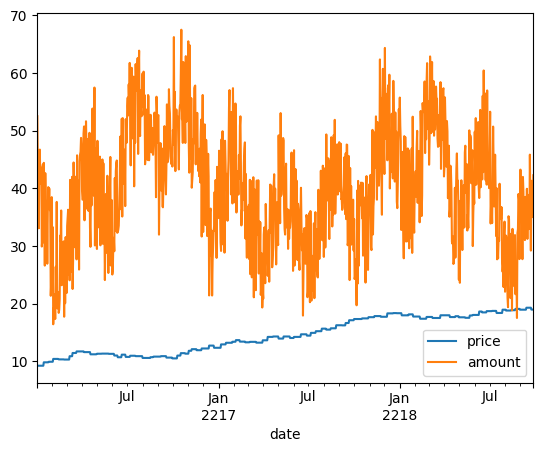

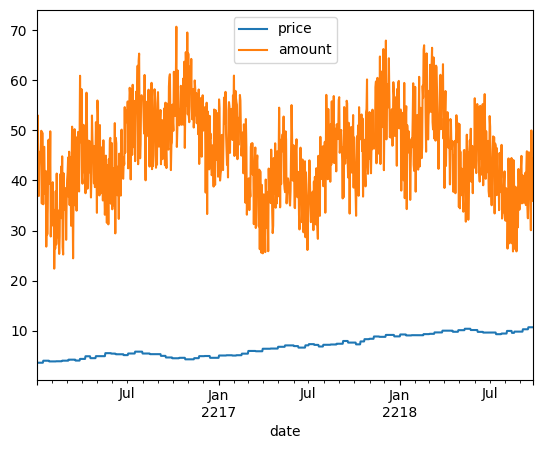

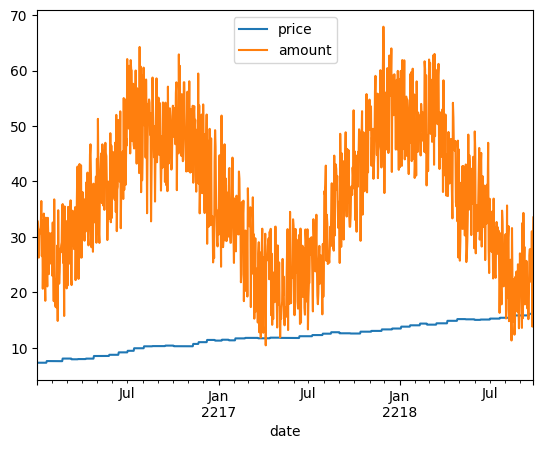

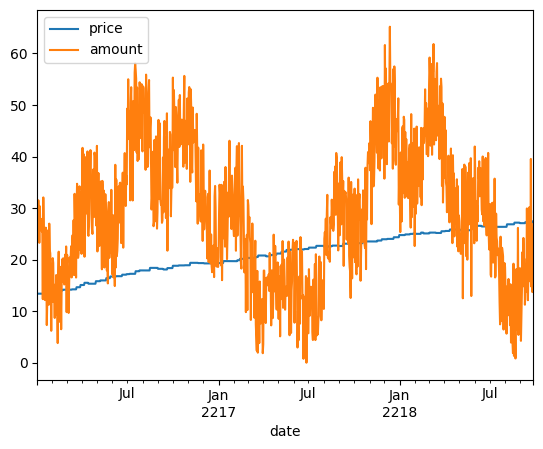

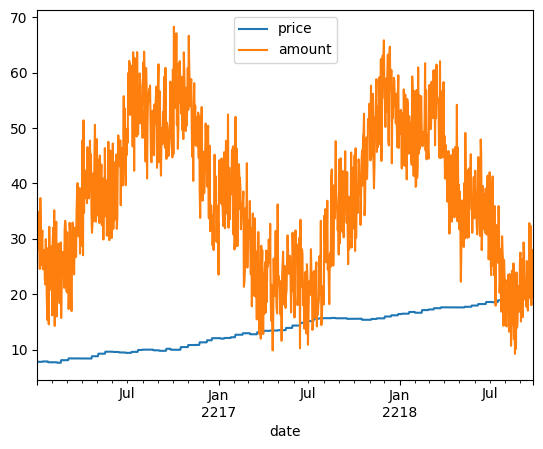

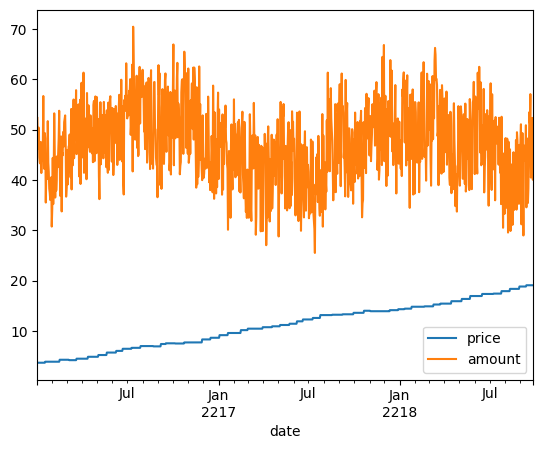

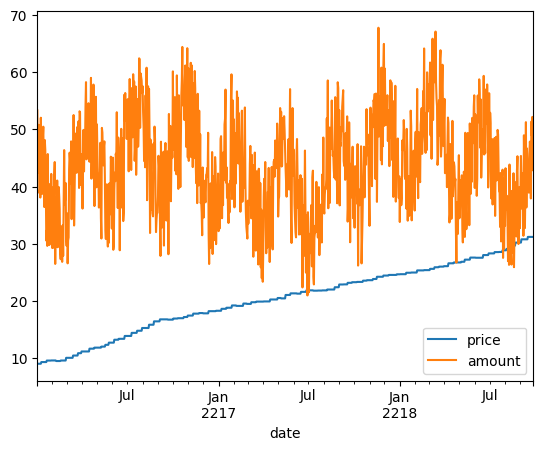

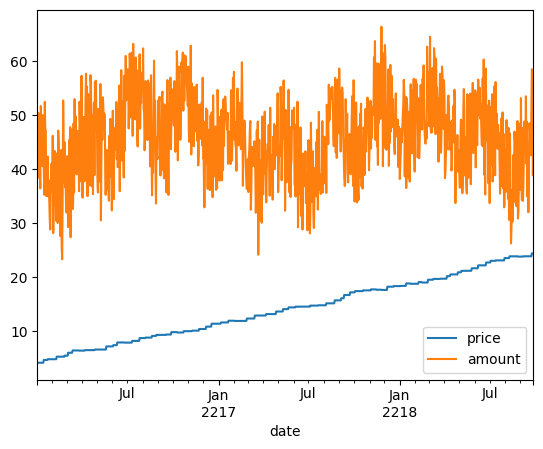

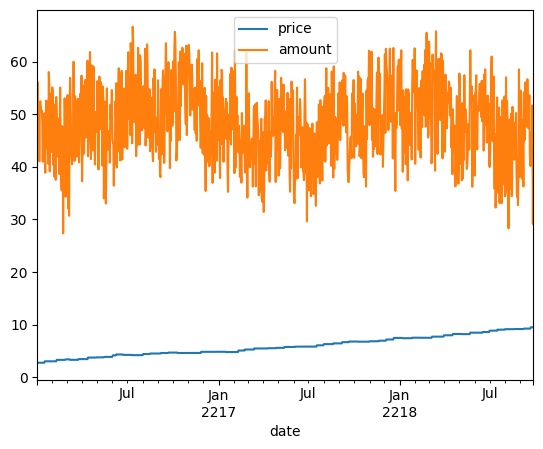

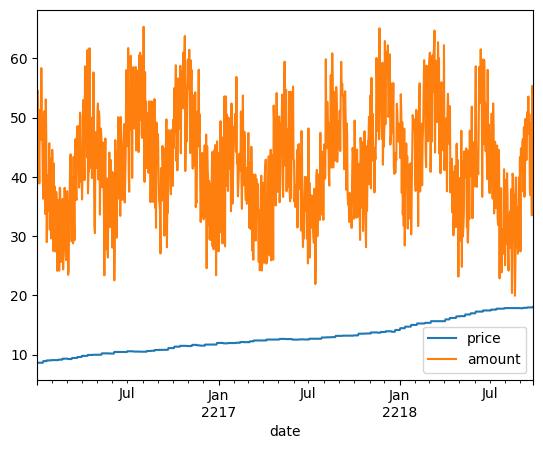

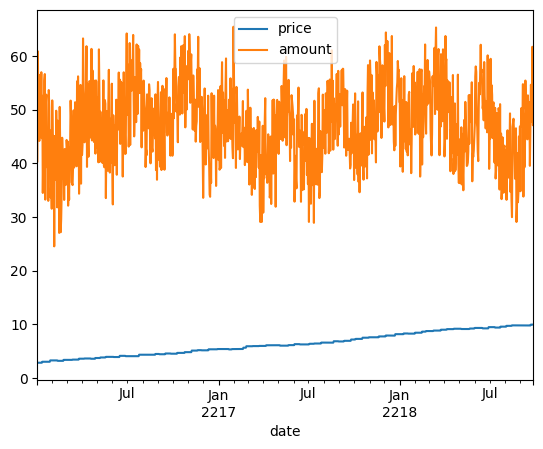

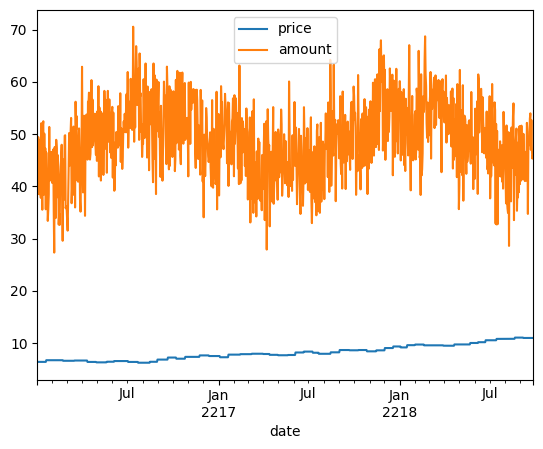

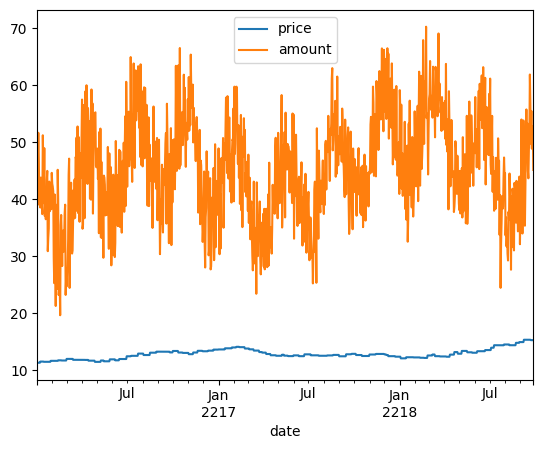

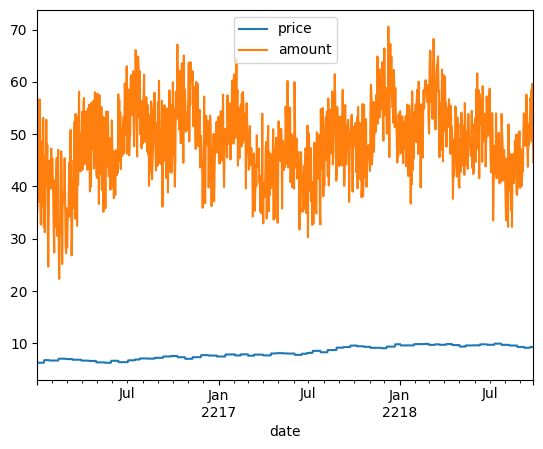

In [9]:
for (place, product), df in df_transaction.groupby(["place", "product"]):
    df.plot()

In [10]:
# Беру максимальные цены среди всех конкурентов для каждого города и продукта в каждый день
# Именно максимальную цену, чтобы прогнозировать максимальные цену, 
# которая дальше нужна будет для формирования условия "Штраф, если ваша цена на 20% выше, чем у конкурентов", 
# которое я трактую как "Штраф, если ваша цена на 20% выше, чем у ВСЕХ конкурентов", хотя можно было бы
# "Штраф, если ваша цена на 20% выше, чем у КАКОГО-ТО ИЗ конкурентов"

df_competitors = df_competitors[["place", "product", "price", "date"]].groupby(["place", "product", pd.Grouper(key='date',freq='D')]).max().reset_index()
df_competitors = df_competitors.set_index("date").sort_index()
df_competitors.rename(columns={'price': 'competitor_price'}, inplace=True)
df_competitors

,place,product,competitor_price
date,,,
2216-01-02,Анор Лондо,Целебные травы,4.21
2216-01-02,Нокрон,Эльфийская пыльца,8.35
2216-01-02,Врата Балдура,Эстус,8.45
2216-01-02,Фалькония,Эльфийская пыльца,11.97
2216-01-02,Нокрон,Целебные травы,3.07
...,...,...,...
2218-09-27,Врата Балдура,Эстус,21.97
2218-09-27,Кеджистан,Эльфийская пыльца,31.81
2218-09-27,Анор Лондо,Эстус,10.91


In [11]:
# Видно, что есть 702 недостающию строки
# Добавляю их в датафрейм, и ставлю среднее значение по нескольким соседним дням на место отсутсвующих цен.

date_range = pd.date_range("2216-01-02", "2218-09-27")
added = list()
for (place, product), df in df_competitors.groupby(["place", "product"]):
    for date in date_range:
        if date not in df.index:
            one = datetime.timedelta(days = 1)
            price = [df.loc[date + i * one]["competitor_price"] for i in [-1, 1, 2] if (date + i * one) in df.index]
            added.append([date, place, product, sum(price) / len(price)])

In [12]:
temp_df = pd.DataFrame(added, columns=["date", "place", "product", "competitor_price"]).set_index("date")
df_competitors = pd.concat([df_competitors, temp_df]).sort_index()

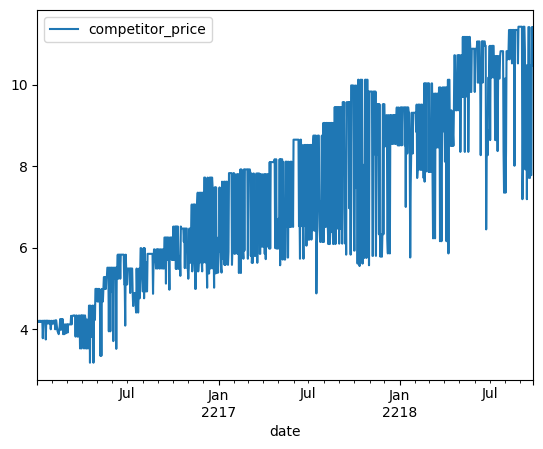

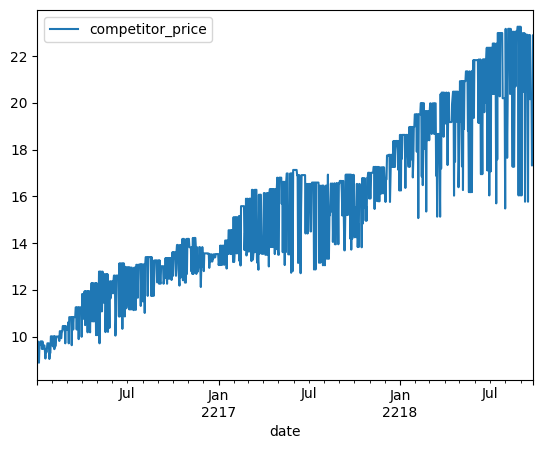

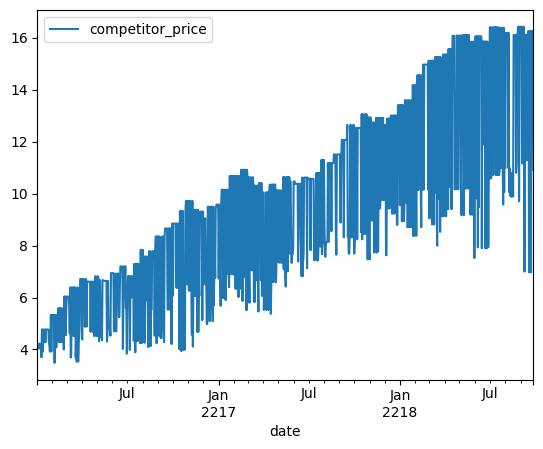

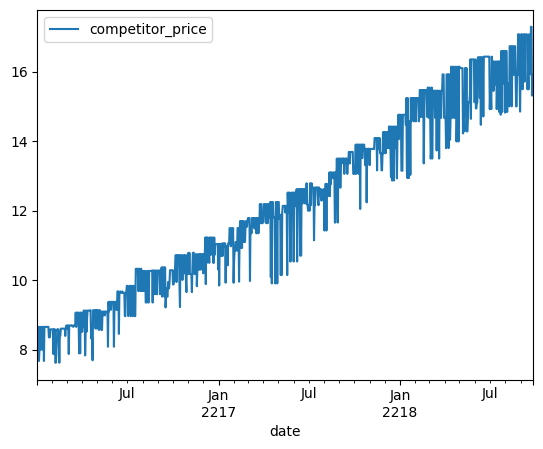

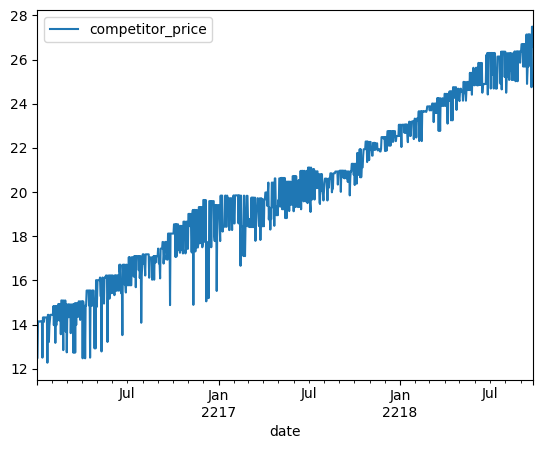

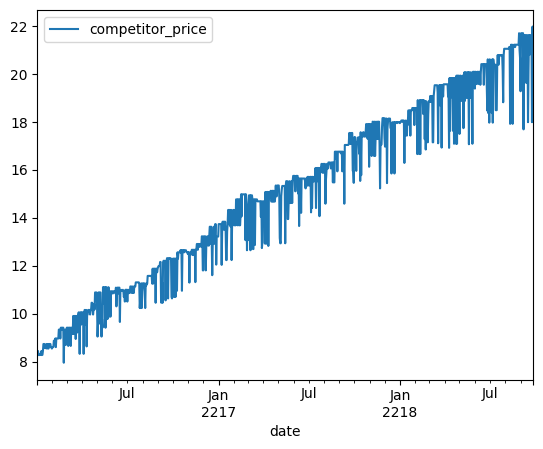

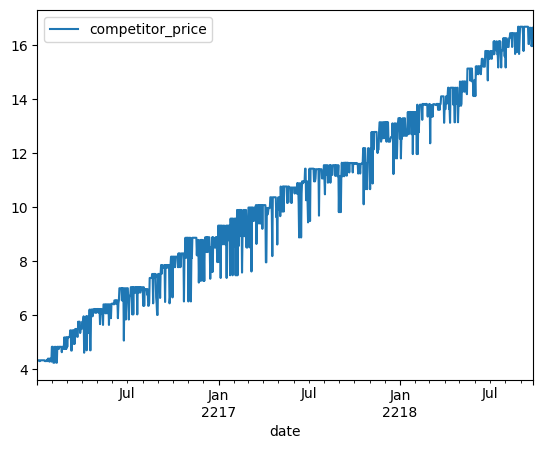

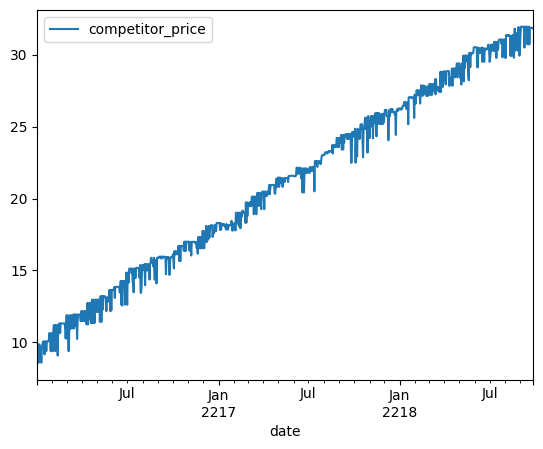

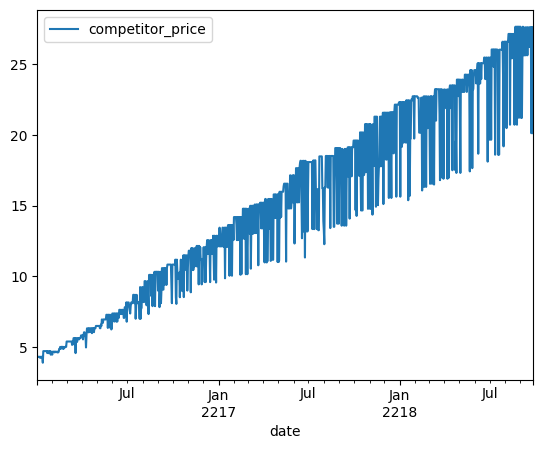

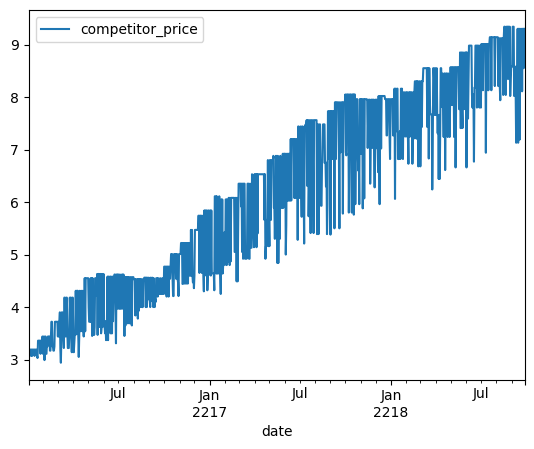

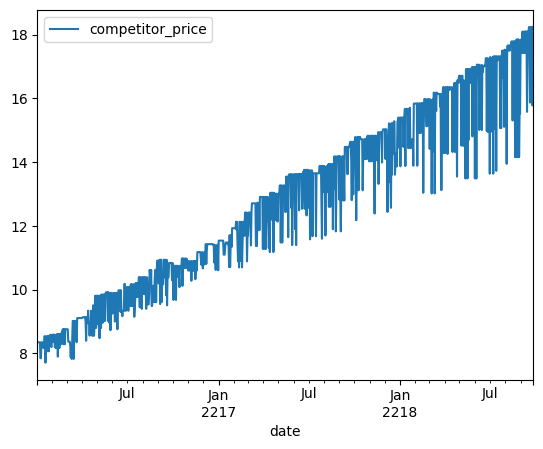

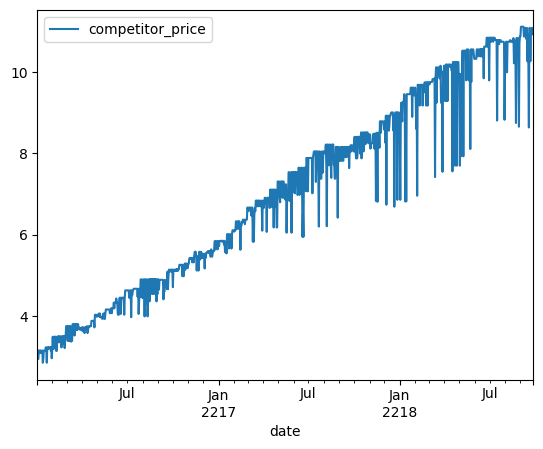

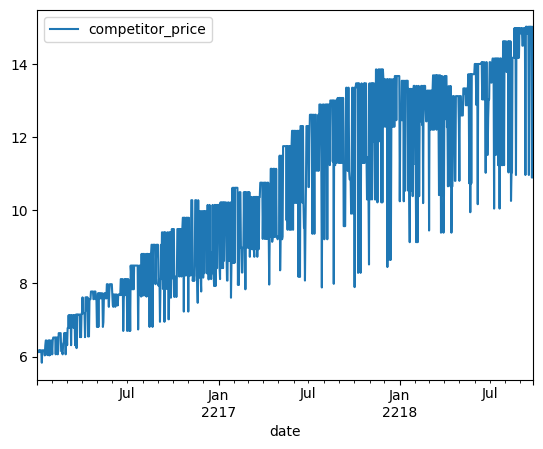

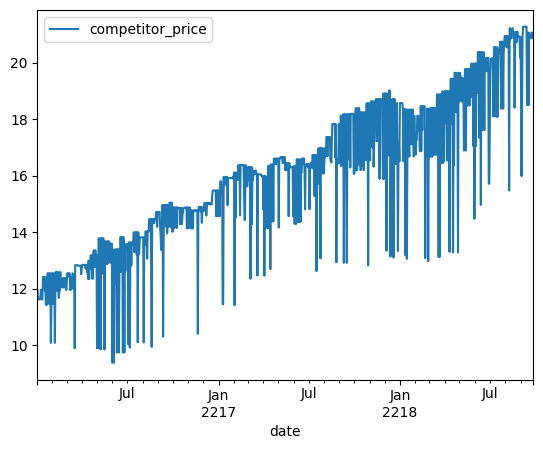

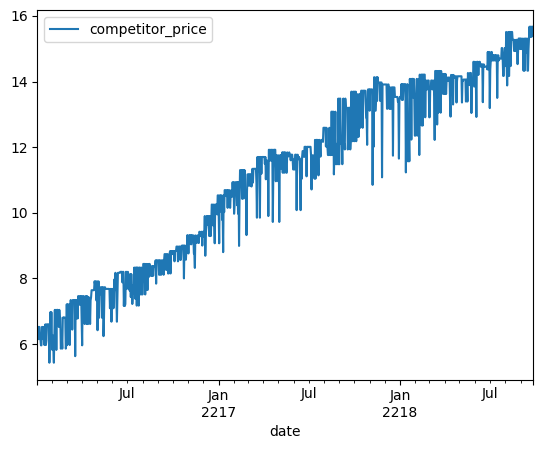

In [13]:
for (place, product), df in df_competitors.groupby(["place", "product"]):
    df.plot()

In [14]:
df_cost = df_cost.set_index("date").sort_index()
df_cost

,place,product,cost
date,,,
2216-01-02,Анор Лондо,Целебные травы,2.07
2216-01-02,Нокрон,Целебные травы,1.47
2216-01-02,Фалькония,Целебные травы,4.55
2216-01-02,Анор Лондо,Эльфийская пыльца,3.46
2216-01-02,Врата Балдура,Эльфийская пыльца,5.92
...,...,...,...
2218-09-27,Нокрон,Эстус,5.39
2218-09-27,Врата Балдура,Эстус,7.86
2218-09-27,Кеджистан,Эстус,10.15


In [15]:
# Видно, что есть очень много  недостающих строки (15000 - 1117 = 13883 штук)

# Добавляю их в датафрейм, и ставлю последнее значение, которое было для данного товара и города.

date_range = pd.date_range("2216-01-02", "2218-09-27")
added = list()
for (place, product), df in df_cost.groupby(["place", "product"]):
    last = np.nan
    for date in date_range:
        if date not in df.index:
            added.append([date, place, product, last])
        else:
            last = df.loc[date]["cost"]

In [16]:
temp_df = pd.DataFrame(added, columns=["date", "place", "product", "cost"]).set_index("date")
df_cost = pd.concat([df_cost, temp_df]).sort_index()

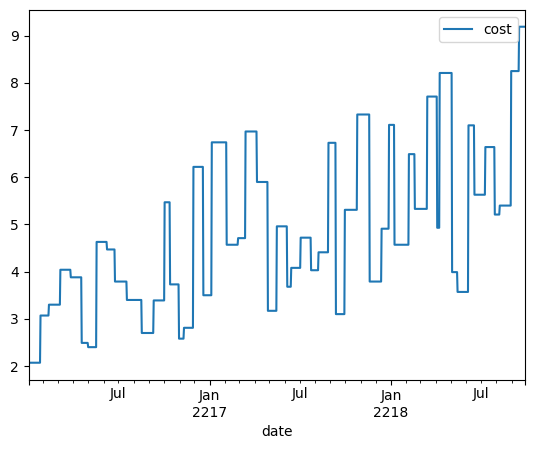

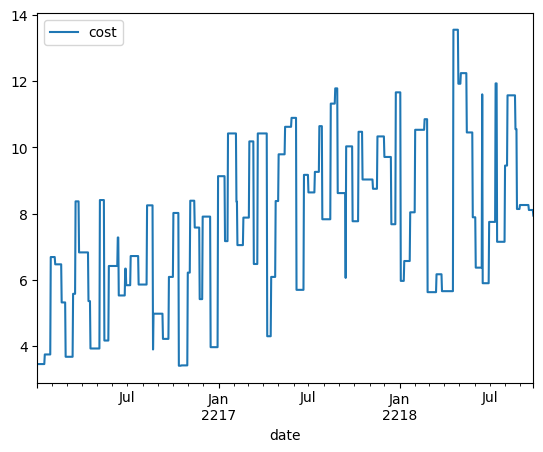

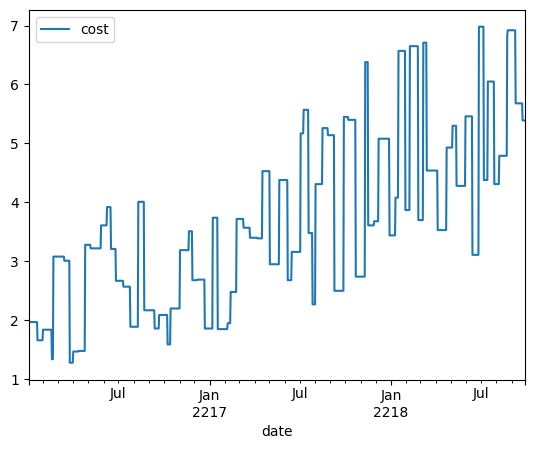

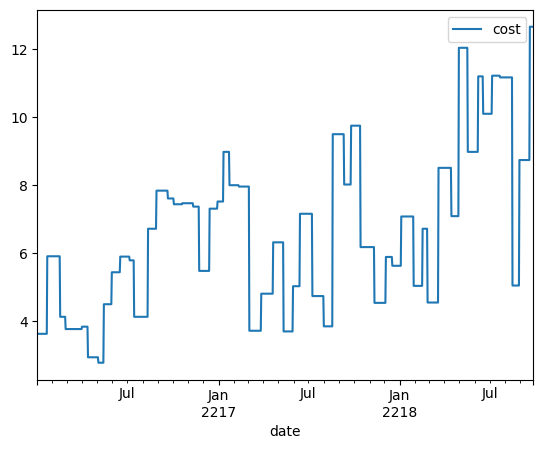

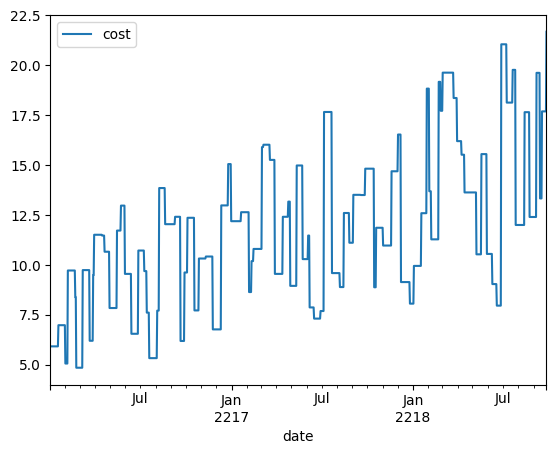

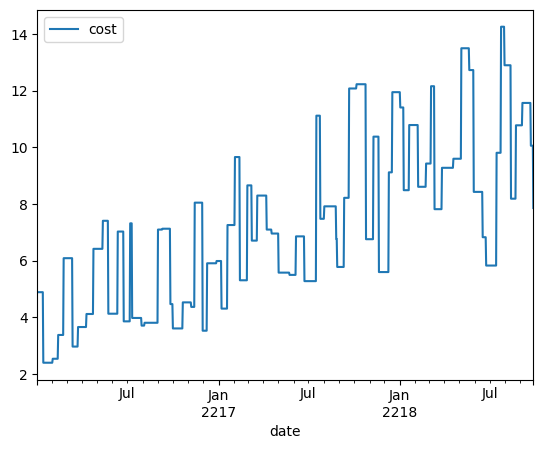

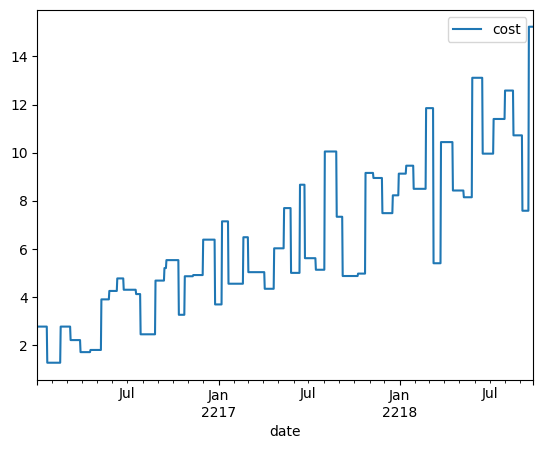

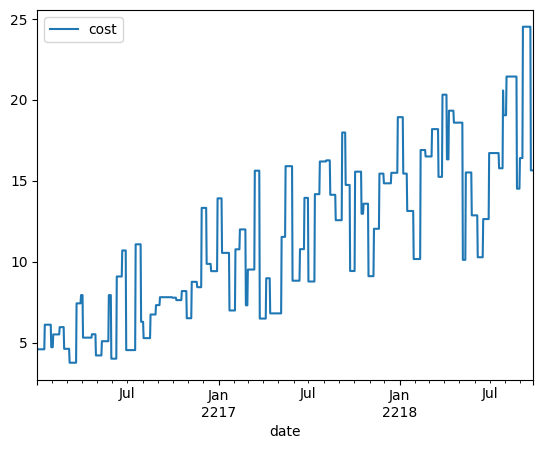

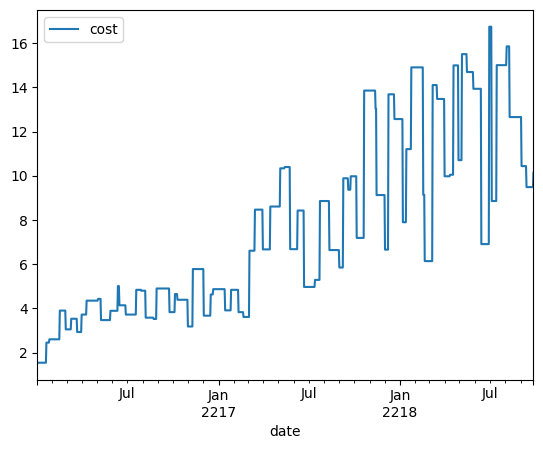

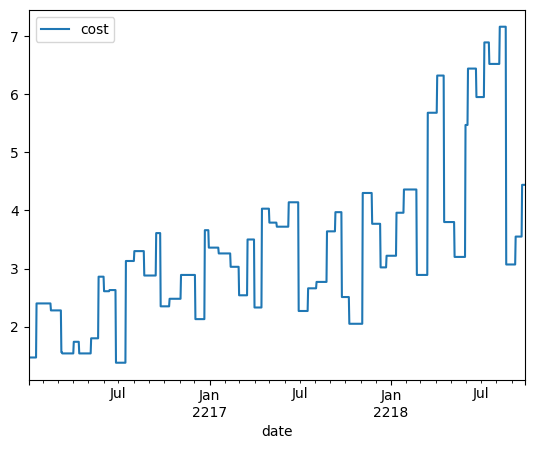

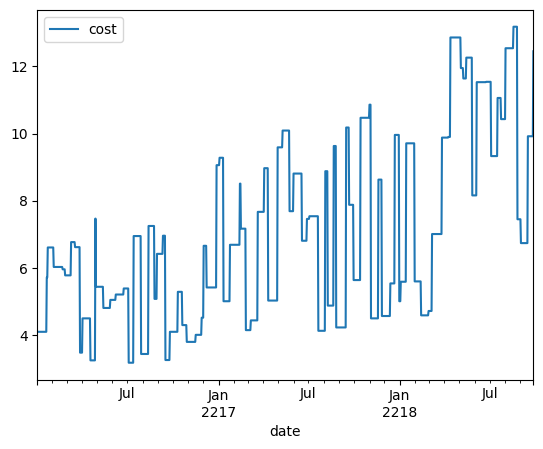

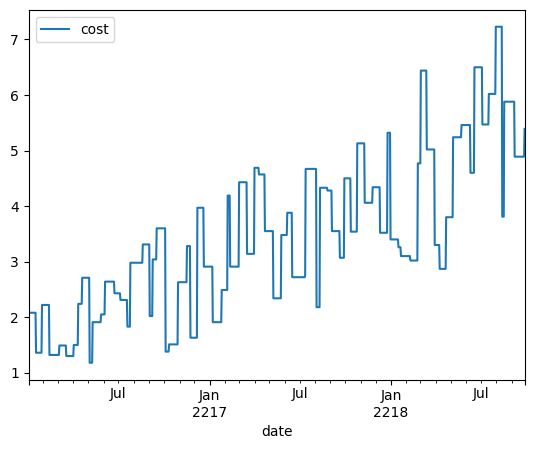

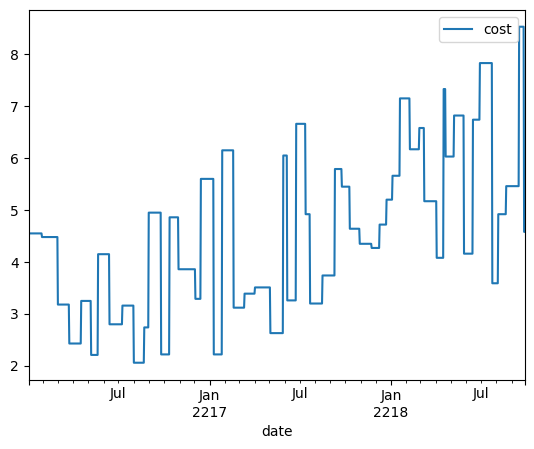

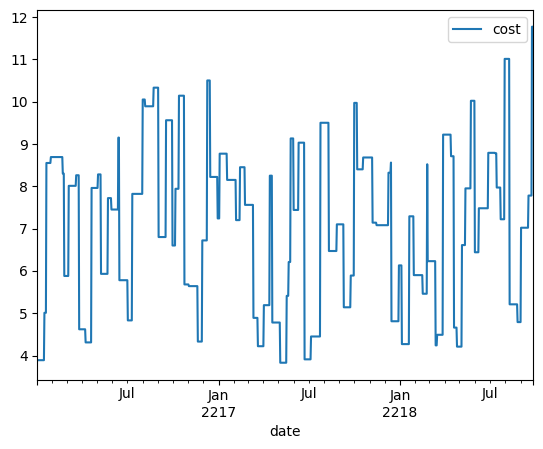

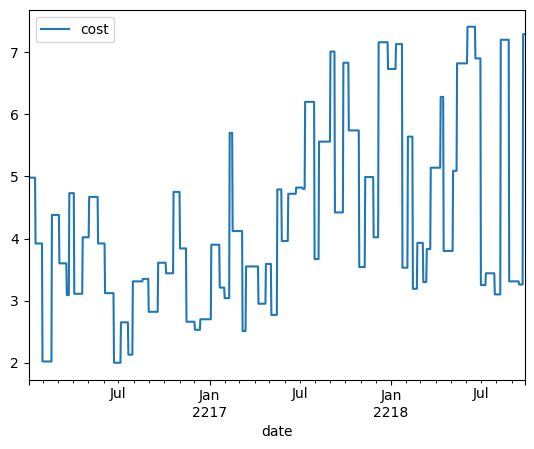

In [17]:
for (place, product), df in df_cost.groupby(["place", "product"]):
    df.plot()

In [18]:
df_weather = df_weather.set_index("date").sort_index()
df_weather

,place,hot,rain,snow
date,,,,
2216-01-02,Фалькония,0,0,0
2216-01-02,Анор Лондо,1,0,0
2216-01-02,Врата Балдура,0,0,1
2216-01-02,Нокрон,0,0,0
2216-01-02,Кеджистан,0,0,1
...,...,...,...,...
2218-09-27,Фалькония,0,0,0
2218-09-27,Анор Лондо,0,0,1
2218-09-27,Врата Балдура,1,0,0


In [19]:
# Объединяю все данные, которые получил выше

df_all = pd.merge(df_transaction, df_weather,  how='inner', on=["date", "place"])
df_all = pd.merge(df_all, df_competitors,  how='inner', on=["date", "place", "product"])
df_all = pd.merge(df_all, df_cost,  how='inner', on=["date", "place", "product"])

In [20]:
df_all

,place,product,price,amount,hot,rain,snow,competitor_price,cost
date,,,,,,,,,
2216-01-02,Анор Лондо,Целебные травы,3.90,37.802874,1,0,0,4.21,2.07
2216-01-02,Анор Лондо,Эстус,3.60,46.831999,1,0,0,4.13,1.97
2216-01-02,Анор Лондо,Эльфийская пыльца,9.21,52.490108,1,0,0,9.79,3.46
2216-01-02,Кеджистан,Эльфийская пыльца,9.05,53.296328,0,0,1,8.85,4.58
2216-01-02,Кеджистан,Целебные травы,3.69,52.348454,0,0,1,4.33,2.78
...,...,...,...,...,...,...,...,...,...
2218-09-27,Анор Лондо,Целебные травы,13.63,37.672160,0,0,1,10.47,9.19
2218-09-27,Анор Лондо,Эстус,10.68,44.420709,0,0,1,10.91,5.39
2218-09-27,Врата Балдура,Эстус,20.33,25.646198,1,0,0,21.97,7.86


In [481]:
# создаю словарь, где ключи это (place, product), а значение - соответсвующий датафрейм

df_dict = dict()

for (place, product), df in df_all.groupby(["place", "product"]):
    cur_df = df[["price", "amount", "hot", "rain", "snow", "competitor_price", "cost"]]
    a = [np.nan for _ in range(1000)]
    col = [
            pd.date_range("2218-09-28", "2218-12-26"),
            a, a, a, a, a, a, a
    ]
    df2 = pd.DataFrame(list(zip(*col)), columns=cur_df.reset_index().columns).set_index("date")
    cur_df = pd.concat([cur_df, df2])
    df_dict[place, product] = cur_df

In [482]:
df_dict_keys = list(df_dict.keys())

In [483]:
def predict_weather(place, product):
    """
    Запись предсказаний погоды на следующие 90 дней
    Формирую их как погоду в эти же 90 дней, но прошлого года
    """
    df = df_dict[place, product]
    dates = df.index[-90 - 365:-365]
    df.loc[df.index[-90:], "hot"] = df.loc[dates, "hot"].values
    df.loc[df.index[-90:], "rain"] = df.loc[dates, "rain"].values
    df.loc[df.index[-90:], "snow"] = df.loc[dates, "snow"].values

In [484]:
def predict_competitor_price(place, product):
    """
    Предсказание цен конкурентов.
    Использую фичи с prophet (сезонность, тренд и т.д.) и погодные факторы,
    а дальше кладу это в LGBMRegressor, получаю прогноз на 90 дней и записываю его
    """
    
    df = df_dict[place, product]
    p_df = df[["competitor_price"]].reset_index().rename(columns={'date': 'ds', 'competitor_price': 'y'})
    X = df[["hot", "rain", "snow"]]
    y = df["competitor_price"].values
    
    m = Prophet(
        growth='linear',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False
    )
    m.add_seasonality(name='500_seasonality', period=504, fourier_order=3)
    m.add_seasonality(name='quarter_seasonality', period=91, fourier_order=10)
    m.fit(p_df)

    prophet_data = m.predict(p_df.drop('y', axis=1))
    X_prophet = prophet_data.drop('yhat', axis=1).set_index("ds").rename(columns={'y': 'competitor_price'})
    
    X = pd.concat([X, X_prophet], axis=1)[[
        "hot", "rain", "snow", "trend", "500_seasonality", 
        "additive_terms", "quarter_seasonality", "weekly"
    ]]

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X.iloc[:-90], y[:-90], test_size=0.33)
    
    booster = lgb.LGBMRegressor(objective="regression_l2", verbose=-1, n_estimators=100)
    booster.fit(X_train, Y_train, eval_set=[(X_test, Y_test),], eval_metric="rmse")

    # print(f"Competitor price R2 Score on train({place}, {product}):", r2_score(booster.predict(X_train), Y_train))
    print(f"Competitor price R2 Score on test({place}, {product}):", r2_score(booster.predict(X_test), Y_test))
    
    df.loc[df.index[-90:], "competitor_price"] = booster.predict(X)[-90:]


In [485]:
def predict_amount(place, product):
    """
    Предсказание спроса.
    Использую фичи с prophet (сезонность, тренд и т.д.), погодные факторы, и цены конкурентов,
    а дальше кладу это в LGBMRegressor, получаю прогноз на 90 дней и записываю его
    """
    
    df = df_dict[place, product]
    p_df = df[["amount"]].reset_index().rename(columns={'date': 'ds', 'amount': 'y'})
    X = df[["hot", "rain", "snow", "competitor_price"]]
    y = df["amount"].values
    
    m = Prophet(
        growth='linear',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False
    )
    m.add_seasonality(name='500_seasonality', period=504, fourier_order=3)
    m.add_seasonality(name='quarter_seasonality', period=91, fourier_order=10)
    m.fit(p_df)

    prophet_data = m.predict(p_df.drop('y', axis=1))
    X_prophet = prophet_data.drop('yhat', axis=1).set_index("ds").rename(columns={'y': 'amount'})
    
    X = pd.concat([X, X_prophet], axis=1)[[
        "hot", "rain", "snow", "competitor_price", "trend", "500_seasonality", 
        "additive_terms", "quarter_seasonality", "weekly"
    ]]

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X.iloc[:-90], y[:-90], test_size=0.33)
    
    booster = lgb.LGBMRegressor(objective="regression_l2", verbose=-1, n_estimators=100)
    booster.fit(X_train, Y_train, eval_set=[(X_test, Y_test),], eval_metric="rmse")

    # print(f"Amount R2 Score on train({place}, {product}):", r2_score(booster.predict(X_train), Y_train))
    print(f"Amount R2 Score on test({place}, {product}):", r2_score(booster.predict(X_test), Y_test))
    
    df.loc[df.index[-90:], "amount"] = booster.predict(X)[-90:]

In [486]:
def predict_cost(place, product):
    """
    Предсказание себестоимости.
    Использую фичи с prophet (сезонность, тренд и т.д.), погодные факторы, и цены конкурентов,
    а дальше кладу это в LGBMRegressor, получаю прогноз на 90 дней и записываю его
    """
    
    df = df_dict[place, product]
    p_df = df[["cost"]].reset_index().rename(columns={'date': 'ds', 'cost': 'y'})
    X = df[["hot", "rain", "snow", "competitor_price"]]
    y = df["cost"].values
    
    m = Prophet(
        growth='linear',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False
    )
    m.add_seasonality(name='500_seasonality', period=504, fourier_order=3)
    m.add_seasonality(name='quarter_seasonality', period=91, fourier_order=10)
    m.fit(p_df)

    prophet_data = m.predict(p_df.drop('y', axis=1))
    X_prophet = prophet_data.drop('yhat', axis=1).set_index("ds").rename(columns={'y': 'cost'})
    
    X = pd.concat([X, X_prophet], axis=1)[[
        "hot", "rain", "snow", "competitor_price", "trend", "500_seasonality", 
        "additive_terms", "quarter_seasonality", "weekly"
    ]]

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X.iloc[:-90], y[:-90], test_size=0.33)
    
    booster = lgb.LGBMRegressor(objective="regression_l2", verbose=-1, n_estimators=100)
    booster.fit(X_train, Y_train, eval_set=[(X_test, Y_test),], eval_metric="rmse")

    # print(f"Cmount R2 Score on train({place}, {product}):", r2_score(booster.predict(X_train), Y_train))
    print(f"Cost R2 Score on test({place}, {product}):", r2_score(booster.predict(X_test), Y_test))
    
    df.loc[df.index[-90:], "cost"] = booster.predict(X)[-90:]
    

In [487]:
# Формирование предсказания для всех городов и товаров

for i in df_dict_keys:
    predict_weather(*i)
    predict_competitor_price(*i)
    predict_amount(*i)
    predict_cost(*i)

Competitor price R2 Score on test(Анор Лондо, Целебные травы): 0.7032561301819241
Amount R2 Score on test(Анор Лондо, Целебные травы): 0.7594435625818992
Cost R2 Score on test(Анор Лондо, Целебные травы): 0.8670260071348974
Competitor price R2 Score on test(Анор Лондо, Эльфийская пыльца): 0.8602405189058826
Amount R2 Score on test(Анор Лондо, Эльфийская пыльца): 0.6838697156594131
Cost R2 Score on test(Анор Лондо, Эльфийская пыльца): 0.7290552697888328
Competitor price R2 Score on test(Анор Лондо, Эстус): 0.46910046287374596
Amount R2 Score on test(Анор Лондо, Эстус): 0.6477055323899357
Cost R2 Score on test(Анор Лондо, Эстус): 0.7838975022130019
Competitor price R2 Score on test(Врата Балдура, Целебные травы): 0.948808353240678
Amount R2 Score on test(Врата Балдура, Целебные травы): 0.874748830098576
Cost R2 Score on test(Врата Балдура, Целебные травы): 0.9478103545684787
Competitor price R2 Score on test(Врата Балдура, Эльфийская пыльца): 0.950222449593169
Amount R2 Score on test(Вра

In [488]:
# Пример результата для первого города, первого товора.

df_dict[df_dict_keys[0]]

,price,amount,hot,rain,snow,competitor_price,cost
date,,,,,,,
2216-01-02,3.9,37.802874,1.0,0.0,0.0,4.210000,2.070000
2216-01-03,3.9,43.264844,1.0,0.0,0.0,4.210000,2.070000
2216-01-04,3.9,35.629889,0.0,0.0,0.0,4.180000,2.070000
2216-01-05,3.9,37.474104,0.0,0.0,0.0,4.180000,2.070000
2216-01-06,3.9,48.586827,0.0,0.0,1.0,4.210000,2.070000
...,...,...,...,...,...,...,...
2218-12-22,NaN,31.902612,0.0,0.0,0.0,9.586085,7.242681
2218-12-23,NaN,46.178233,1.0,0.0,0.0,8.021518,7.156740
2218-12-24,NaN,34.440464,0.0,0.0,0.0,9.811975,7.266280


In [768]:
def optimize_prices(place, product, n=1000):
    """
    Оптимизация цены в следующие 90 дней по данному городу и товару.
    Использую жадный, не оптимальный алгоритм, который иногда вываливается из допустимого
    множества. По каждому дню смотрю для нарезанных цен, какая удовлетворяет ограничениям
    1) не может быть больше на 1, чем предыдущая
    2) не может быть больше на 20%, чем цена конкурента
    3) должна быть неизменна как минимум за 3 последних дня или должна совпадать с последней, 
       если последнее не выполнено
    Из таких цен выбираю наилучшую, при которой прибыль максимальна.
    Так же на месте произвожу запись в датафрейм
    """
    a = 0
    hor = 90
    df = df_dict[place, product]
    price_lb = df["cost"][-hor:].min()
    prices_ub = df["competitor_price"][-hor:].max() 

    prices = np.linspace(price_lb, prices_ub, n)
    prev_prices = list(df["price"][-hor - 3:-hor].values)
    for t in range(hor):
        best_prof = None
        best_qp = prices[0]
        comp = df["competitor_price"].values[-hor+t]
        
        for qp in prices:
            if (qp - prev_prices[-1] <= 1) and (qp <= 1.2 * comp):
                if (qp == prev_prices[-1]) or (prev_prices[0] == prev_prices[1] and prev_prices[0] == prev_prices[2]):
                    current_prof = max(qp - df["cost"].values[-hor+t], 0) * df["amount"].values[-hor+t]
                    if best_prof is None or best_prof < current_prof:
                        best_prof = current_prof
                        best_qp = qp
        if best_prof is None:
            qp_ = prev_prices[-1]
            
        df.loc[df.index[-hor+t], "price"] = best_qp
        prev_prices = [prev_prices[1], prev_prices[2], best_qp]

In [769]:
# произвожу оптимизацию

for i in df_dict_keys:
    optimize_prices(*i, 1000)

In [770]:
df_dict[df_dict_keys[0]]

,price,amount,hot,rain,snow,competitor_price,cost
date,,,,,,,
2216-01-02,3.900000,37.802874,1.0,0.0,0.0,4.210000,2.070000
2216-01-03,3.900000,43.264844,1.0,0.0,0.0,4.210000,2.070000
2216-01-04,3.900000,35.629889,0.0,0.0,0.0,4.180000,2.070000
2216-01-05,3.900000,37.474104,0.0,0.0,0.0,4.180000,2.070000
2216-01-06,3.900000,48.586827,0.0,0.0,1.0,4.210000,2.070000
...,...,...,...,...,...,...,...
2218-12-22,10.834361,31.902612,0.0,0.0,0.0,9.586085,7.242681
2218-12-23,9.623390,46.178233,1.0,0.0,0.0,8.021518,7.156740
2218-12-24,9.623390,34.440464,0.0,0.0,0.0,9.811975,7.266280


In [771]:
# формирую результат

result_df = pd.DataFrame(columns=["day_number", "product", "place", "price"])
for i in df_dict_keys:
    for date, price in enumerate(df_dict[i]["price"][-90:]):
        result_df.loc[-1] = [date + 1, i[1], i[0], price]
        result_df.index = result_df.index + 1
result_df = result_df.sort_values(by=["place", "product", "day_number"], ascending=True).set_index("day_number").reset_index()

In [772]:
result_df.head(20)

,day_number,product,place,price
0,1,Целебные травы,Анор Лондо,10.834361
1,2,Целебные травы,Анор Лондо,10.834361
2,3,Целебные травы,Анор Лондо,6.893774
3,4,Целебные травы,Анор Лондо,6.893774
4,5,Целебные травы,Анор Лондо,6.893774
5,6,Целебные травы,Анор Лондо,6.893774
6,7,Целебные травы,Анор Лондо,6.893774
7,8,Целебные травы,Анор Лондо,6.893774
8,9,Целебные травы,Анор Лондо,6.893774
9,10,Целебные травы,Анор Лондо,6.893774


In [773]:
# записываю результат
result_df.to_parquet('result_df.parquet')